In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import matplotlib.ticker as mticker
import time as t
import scipy

# Defining Constants Used Throughout

In [2]:
### Here we define constants from the QMC model

w1   = 0.3400     ### Fitting constant for sigma meson (unitless)
w2   = 0.3688     ### Fitting constant for sigma meson (unitless)
wom  = 1/3        ### Fitting constant for omega meson (unitless)
d    = 0.176      ### Fitting constant for effective mass in [fm]
MeV  = 197.3      ### Conversion for [fm^-1] -> [MeV]
MX   = 1314.86    ### Mass of Xi baryon in [MeV]
msig = 504/MeV    ### Mass of sigma Meson

### Here we define constants for the Woods-saxon potential
aWS  = 0.6        ### W-S Density constant in [fm]
c    = 1.1        ### W-S Constant multiplying A^1/3 term
rho0 = 0.15       ### Nuclear matter density in [fm^-3]

# Defining Coulomb Potential

The Coulomb potential is defined by the equation:

$$V(r) =  8ke \int dq  \int dr' r'^2 j_0(qr)  \rho_c(r') j_0(qr')$$

Where here $\rho_c$ is the charge density, which goes like the proton density, normalised to the number of protons present.

In [3]:
### Calculating  the normalisation, such that the the integral of the charge density returns Z
def NormCalculator(Z):
    integrand = lambda r, Z: 4*np.pi*r**2/(1+np.exp((r-c*Z**(1/3))/aWS)) 
    norm      = integrate.quad(integrand, 1e-4, 10, args = Z)[0]
    return norm

### Definining the Charge Density, using the normalisation above
def ChargeRho(x, norm, Z):
    val = Z/(norm*(1+np.exp((x-c*Z**(1/3))/aWS)))   
    return val

### Defining the Coulomb potential, as a double integral over r' and q. 
@np.vectorize
def V_Coulomb2(r, norm, Z):
    ### Defining Limits for the r' integral
    Upperlim  = lambda x: 20
    Lowerlim  = lambda x: 1e-4
    ### Integrand to be integrated.
    Integrand = lambda x, q, r, norm, Z: -8*k*Z/r* np.sin(q*r)/q**2*ChargeRho(x, norm, Z)*x*np.sin(q*x)
    return integrate.dblquad(Integrand, 1e-4, 10, Lowerlim, Upperlim, args = (r, norm, Z))

# Defining Potentials and Woods-Saxon Densities

In [4]:
### Defining the Woods-Saxon Density and it's Derivatives

def rho(r, A):
    val = rho0/(1+np.exp((r-c*A**(1/3))/aWS))
    return val

def diffrho(r, A):
    exparg = np.exp((r-c*A**(1/3))/aWS)
    val = rho0*(-2*aWS*(1+exparg)-r*(1-exparg))*exparg/(aWS**2*r*(1+exparg)**3)
    return val

def diff2rho(r,A):
    exparg = np.exp((r-c*A**(1/3))/aWS)
    val = 2*rho0**2*(-2*aWS*(exparg+1)-r*(1-exparg))*exparg/(aWS**2*r*(1+exparg)**4)
    return val

def diffrhosquare(r,A):
    exparg = np.exp((r-c*A**(1/3))/aWS)
    val = -2*rho0*exparg/(aWS*(1+exparg)**3)
    return val

### Defining the many-body potential (No angular part at this stage)

def V(r, A, Z, Gsig, Gom, Grho, VC, l):
    ### Many-body interaction terms
    c1   = -w1*Gsig*MeV + wom*Gom*MeV           ### 2-Body Forces
    c2   =  (d*w2/2+d*w1)*Gsig**2*MeV           ### 3-Body Forces
    c3   = -(d**2*w1+d**2*w2)*Gsig**3*MeV       ### 4-Body Forces
    
    ### Isospin-Dependent term
    b    =  Grho/4 * (rho(r,Z)-rho(r,A-Z))*MeV
    
    
    ### Derivative terms
    drho_drho  =  -d*Gsig**2*(w1+w2)*diffrho(r, A)**2/msig**2*MeV
    drho2_drho =   Gsig**3*d**2*(w1+w2)*diffrho(r,A)*diffrhosquare(r,A)/msig**2*MeV
    d2rho      =   Gsig**3*d**2*(w1+2*w2)*rho(r,A)*diff2rho(r,A)/msig**2*MeV
    
    ### Velocity-Dependent Terms
    Inverse      = 1+(Gsig*rho(r,A)*w1/MX-Gsig**2*rho(r,A)**2*d*(w1+w2/2)/MX+Gsig**3*rho(r,A)**3*d**2*(w1+w2)/MX)*MeV
    Inverse_drho = (w2*d*Gsig**2*diffrho(r,A)**2-Gsig**3*d**2*w2*diffrho(r,A)*diffrhosquare(r,A)-d2rho*msig**2/MeV)*MeV/(MX*msig**2)

    ### Angular Momentum Term
    if l==0:
        Ang = 0
    else:
        Ang  =  l*(l+1)/(2*MX*r**2)*MeV**2
    
    ### Returning the final result
    result = (c1*rho(r,A)+c2*rho(r,A)**2+c3*rho(r,A)**3+VC+b+drho_drho + drho2_drho +d2rho)/(Inverse+Inverse_drho)+Ang
    
    return result

## Second form for the Potential

The velocity dependent term also modifies the energy eigenvalue, and thus I had to include a second function for inputting into the Numerov Algorithm which accounts for this. We have here:
$\frac{(E-V(r))}{\text{Velocity-dependent terms}}$

And we note that from rearranging the Hamiltonian from the EoM that the angular momentum term is unaffected by the velocity-dependence, so we simply add it to the other term involved.

In [5]:
### Defining New form for Potential w/ fix for Velocity-dependence
def VTwo(r, A, Z, E, Gsig, Gom, Grho, VC, l):
    c1   = -w1*Gsig*MeV + wom*Gom*MeV            ### 2-Body Forces
    c2   =  (d*w2/2+d*w1)*Gsig**2*MeV            ### 3-Body Forces
    c3   = -(d**2*w1+d**2*w2)*Gsig**3*MeV        ### 4-Body Forces    
    
    ### Derivative terms
    drho_drho  =   -d*Gsig**2*(w1+w2)*diffrho(r, A)**2/msig**2*MeV
    drho2_drho =   Gsig**3*d**2*(w1+w2)*diffrho(r,A)*diffrhosquare(r,A)/msig**2*MeV
    d2rho      =   Gsig**3*d**2*(w1+2*w2)*rho(r,A)*diff2rho(r,A)/msig**2*MeV
    
    Inverse      = 1+(Gsig*rho(r,A)*w1/MX-Gsig**2*rho(r,A)**2*d*(w1+w2/2)/MX+Gsig**3*rho(r,A)**3*d**2*(w1+w2)/MX)*MeV
    Inverse_drho = (w2*d*Gsig**2*diffrho(r,A)**2-Gsig**3*d**2*w2*diffrho(r,A)*diffrhosquare(r,A)-d2rho*msig**2/MeV)*MeV/(MX*msig**2)
   
    b    =  Grho/4 * (rho(r,Z)-rho(r,A-Z))*MeV
    
    if l==0:
        Ang = 0
    else:
        Ang  =  l*(l+1)/(2*MX*r**2)*MeV**2

    result = E-((c1*rho(r,A)+c2*rho(r,A)**2+c3*rho(r,A)**3+VC+b+drho_drho +d2rho + drho2_drho)/(Inverse+Inverse_drho)+Ang)
    
    return result    

## Defining Classical Turning Point Function

Now we will define some functions which will help to find solutions. We have one function which finds the classical turning point, which is the point where $E-V(r)$, changes sign. When solving using the numerov algorithm we will solve from either side, and match the solutions at the matchpoint which will be this classical turning point.

In [6]:
### Function to find the classical turning point of the potential

def ClassicalTurningPoint(x, N, A, Z, E, Gsig, Gom, Grho, VC, l):
    ### Initialise the matchpoint to be at N//5
    imatch=N//5

    VVec = VTwo(x, A, Z, E, Gsig, Gom, Grho, VC, l)
    ### Loop through to find classical turning point
    for j in range(N-1): 
        DE1 = VVec[j]
        DE2 = VVec[j+1]
        D1D2=DE1*DE2
        if D1D2<=0  and DE1 > 0: 
            imatch = j+1
    return imatch

# Implementing The Numerov Algorithm

The numerov algorithm is used to solve equations of the form:
$\frac{d^2 y}{dx^2} = f(x)y(x)$.

When applying this to solve the schrodinger in this situation, the equation we have is in the form:

$\frac{d^2\psi}{dr^2} = -2M_\Lambda \left[ \frac{1}{\eta(r)}[E - V_{binding}(r)] -\frac{l(l+1)}{2M_\Lambda r^2} \right]\psi(r)$, which is in the form $\frac{d^2 \psi}{dr^2} = f(r)y(r)$

Where here, $\eta(r)$ is the velocity dependent term, which has the form: $\eta(r) = \left[1+ \frac{1}{M_\Lambda}G_\sigma w \rho_N  - \frac{1}{M_\Lambda}\left( w+\frac{\tilde{w}}{2}\right) dG_\sigma^2 \rho_N^2  +\frac{1}{M_\Lambda}\left( w +  \tilde{w} \right)  d^2G_\sigma^3 \rho^3_N \right]$.

$V_{binding}(r)$ is the binding potential, which has the form: $V_{binding} = -G_\sigma w \rho_N(r) +w_\omega G_\omega  \rho_N(r) + \left( w+\frac{\tilde{w}}{2}\right) dG_\sigma^2 \rho_N^2(r)  -\left( w +  \tilde{w} \right)  d^2G_\sigma^3 \rho^3_N(r) + V_{Derivative}$.

Where $V_{Derivative}$ are the derivative terms, and the final term is the term containing the angular momentum dependence.

We note then that calling the function VTwo in the code is calling $f(r)$, as in the algorithm above, up to a factor of $2M_\Lambda$, which is instead included in the numerov solver below.

In [7]:
### Code to implement the Numerov Algorithm, for the left and right Solutions


def NumerovLeft(x, psi0, psi1, A, Z, E, h, Gsig, Gom, Grho, VC, l, imatch):
    
    VVec = VTwo(x, A, Z, E, Gsig, Gom, Grho, VC, l)
    h2 = h**2
    h12 = h2/12
    
    mh12 = 2*MX*h12/(MeV**2)
    
    PsiL = np.zeros(imatch)
    
    PsiL[0] = psi0
    PsiL[1] = psi1
    
    for i in range(2, imatch):
        W2 = 1+mh12*(VVec[i])
        W1 = 2*(1-(5*mh12)*(VVec[i-1]))*PsiL[i-1]
        W0 = (1+mh12*(VVec[i-2]))*PsiL[i-2]
        
        PsiL[i] = (W1-W0)/W2
    
    return PsiL
    
def NumerovRight(x, psiN, psiNm1, A, Z, E, h, Gsig, Gom, Grho, VC, l, imatch):
    
    VVec = VTwo(x, A, Z, E, Gsig, Gom, Grho, VC, l)
    
    h2 = h**2
    h12 = h2/12
    dim = N-imatch
    
    mh12 = 2*MX*h12/(MeV**2)
        
    PsiR    = np.zeros(dim)
    PsiR[0] = psiN
    PsiR[1] = psiNm1
    
    for i in range(2, dim):
        W2 = 1+mh12*(VVec[i])
        W1 = 2*(1-(5*mh12)*(VVec[i-1]))*PsiR[i-1]
        W0 = (1+mh12*(VVec[i-2]))*PsiR[i-2]
        
        PsiR[i] = (W1-W0)/W2
       
    PsiR = np.flip(PsiR)
    return PsiR

# Defining a Function to find Energy Eigenstate

We now have functions to calculate the wavefunction for a given energy, so we now need to put this together to find a valid energy eigenstate. This process works by:

1. We make an initial guess for what the energy should be

2. Solve for the wavefunction for the given energy using the numerov algorithm. We solve the equation by finding the classical energy turning point, and integrating from the left to the match point, and indenpendently from the right to the match point. This allows for us to test whether the energy is a valid energy eigenstate, and also helps to minimise numerical errors.

3. We then enforce continuity by scaling the left side solution to match that at the right side

4. After normalising the wavefunction we can test for smoothness. If the wavefunction is smooth we have found a valid energy eigenstate. If it is not then we increment the energy by an amount dE until we find a valid solution.

5. Once we have a valid solution it is possible that there would be some uncertainty in the exact value for the energy, so we continue to increment by dE and test for a solution. Once the solution is no longer valid for a given energy we have found an upper and lower bound for the energy eigenstate.


In [8]:
def Find_Energy(x, A, Z, Ein, dE, Gsig, Gom, Grho, VC, l, psi0, psi1, psiNm1, psiN, maxit, eps):
    
    E     = Ein
    Psi   = np.zeros(N)
    
    check = 0
    Eerr  = 0
    dE = np.abs(dE)
    for i in range(maxit):
        
        ### Finding Solutions to the Schrodinger Equation
        matchP = ClassicalTurningPoint(x, N, A, Z, E, Gsig, Gom, Grho, VC, l)
        PsiL = NumerovLeft(x, psi0, psi1, A, Z, E, h, Gsig, Gom, Grho, VC, l, matchP)
        PsiR = NumerovRight(x, psiN, psiNm1, A, Z, E, h, Gsig, Gom, Grho, VC, l, matchP)
        
        
        ### Ensuring Continuity by scaling the functions, at the match point.
        PsiLm = PsiL[matchP-1]
        PsiRm = PsiR[0]
        scale = PsiLm/PsiRm
        PsiR  = scale*PsiR
        
        ### Normalising Psi, before testing for Smoothness
        Psi     = np.concatenate((PsiL, PsiR), axis=None)
        Psi2    = np.abs(Psi**2)
        Norm    = integrate.simps(4*np.pi*Psi2, x)
        PsiNorm = Psi/np.sqrt(Norm)
        
        ### Testing for Smoothness
        
        PsiLmm1 = PsiL[matchP-2]
        PsiRmp1 = PsiR[1]
        diff = np.abs(PsiLmm1+PsiRmp1-2*PsiLm)/(2*np.sqrt(Norm)*h)        ### Find Higher-order derivative checker
        
        ### Iterating to find the solution to the energy
        ### First we would have found the lower bound for the energy 
        ### This is because we add to the energy inputted (which has a negative value)
        ### So we check if we find the lower bound, then shift to find the upper
        if diff<eps and check==0:
            ### Set the lower bound for the energy
            Elow  = E
            E     = E+dE
            Eup   = E
            ### Setting the check to 1, so the program knows we are searching for the upper bound
            check = 1
            
       
        ### Now we continue iterating to find the upper bound
        elif diff<eps and check==1:
            Eup = E
            E   = E+dE
        
        ### Now once we find a solution where the derivative is greater than the allowed error
        ### we calculate the mean energy and the uncertainity in the energy.
        elif diff>eps and check==1:
            E = (Eup+Elow)/2            ### Return the Mean energy
            Eerr = np.abs((Eup-Elow)/2) ### And return the uncertainty in the energy
            
            ### We break out of the loop once the energy has been found
            print('Energy Found for A', A, 'And l', l, 'Energy is,', E)
            break
       
        ### This step is for iterating before we have found the lower bound
        else:
            E = E+dE
        
    return E, Eerr

# Function to find Energy Eigenstates of multiple Nuclei

We now wish to calculate all the binding energies for a variety of different nuclei. This is done by:

1. Take an initial energy, as an input to the function, for the first nucleus, and then solve for the energy for the 1s state.
3. Set the new input energy as the upper bound for the energy, plus an increment dE
4. Continue to solve for the energy in all the other 1s states. Note it is important that the nucleon number is in descending order for AsVec and ApVec. This ensures that the ground state is found and not higher energy states for example.
5. Set the energy input back to the energy found for the first nucleus, plus a little increment, to solve for the 1p states, repeating steps 2-4 for the 1p states

In [9]:
def Find_Energies(x, AsVec, ApVec, ZVec, XI0, Ein, dE, Gsig, Gom, Grho, psi0, psi1, psiNm1, psiN, maxit, eps):
    
    NsVec = np.size(AsVec)
    NpVec = np.size(ApVec)
    
    
    ### Initialise vectors and Normalisation for charge density
    EVec      = np.zeros(NsVec+NpVec)
    EerrVec   = np.zeros(NsVec+NpVec)
    Norm = 0
    
    ### Initialising Coulomb Potential Vector
    
    VC = np.zeros(np.size(x))
    
    ### Ensuring Correct sign for the Isospin-Dependent Term
    if XI0 == False:
        Grho = -Grho
        
    ### Loop over energy eigenvalues, updating the Energy in the code each time
    l=0
    for i in range(NsVec):   
        ### Calculating Coulomb Potential if dealing with the negative cascade
        if XI0 == False:
            Norm = NormCalculator(ZVec[i])
            VC, Err = V_Coulomb2(x, Norm, ZVec[i])
        ### Calculating Energy eigenvalues, before setting new energy
        EVec[i], EerrVec[i] = Find_Energy(x, AsVec[i], ZVec[i], Ein, dE, Gsig, Gom, Grho, VC, l, psi0, psi1, psiNm1, psiN, maxit, eps)
        Ein                 = EVec[i]
        ### Due to Isospin-dependent term there is a jump in the binding energy when going to a nucleus with N=Z
        ### This ensures the energy in is sufficiently low to find the 1s state for the next nucleus
        if AsVec[i] <= ACa:
            Ein = EVec[i] - 1
    
    ### Repeating above for the 1p state
    l=1
    ### Setting initial energy to that of the the largest sized nuclei, in its 1s state
    Ein = EVec[0]
    for j in range(NpVec): 
        ### Finding Coulomb Potential if dealing with the negative cascade
        if XI0 == False:
            Norm = NormCalculator(ZVec[j])
            VC, Err = V_Coulomb2(x, Norm, ZVec[j])
            ### Once again dealing with the jump in binding energy due to the Isospin-dependent interaction
            if ApVec[j] == ACa:
                Ein = EVec[NsVec+j]
        ### Calculating the energy eigenvalue for 1p states, before setting the new energy in 
        EVec[NsVec+j], EerrVec[NsVec+j] = Find_Energy(x, ApVec[j], ZVec[j], Ein, dE, Gsig, Gom, Grho, VC, l, psi0, psi1, psiNm1, psiN, maxit, eps)
        Ein                                  = EVec[j+1]+dE
    return EVec, EerrVec

# Defining the Constants used in the Solutions

In [10]:
###Defining the grid for the solution
N = 4000
L = 50
h = L/N
x = np.linspace(1e-4, L, N)

### Defining Function Parameters for Numerov Algorithm

dE  = 0.01
eps = 1e-3
maxit = 1000

### Boundary Conditions
psi0 = 0
psi1 = 0.0001
psiN = 0.000001
psiNm1 = 0.000005

### Defining the Nucleon and Proton numbers for nuclei

APb = 208
ALa = 139
AY  = 89
AV  = 51
ACa = 40
AS  = 32

ZPb = 82
ZLa = 57
ZY  = 39
ZV  = 23
ZCa = 20
ZS  = 16


### Defining a vector containing the nucleon and proton numbers
AVec     = [APb, ALa, AY, AV, ACa, AS]
AVec1p   = [APb, ALa, AY, AV, ACa, AS]
ZVec     = [ZPb, ZLa, ZY, ZV, ZCa, ZS]

In [11]:
### Coupling Constants
Gsig = 8.65
Gom  = 5.64
Grho = 4.71

### Initial Energy in MeV
Ein = np.amin(V(x, APb, ZPb, Gsig, Gom, Grho, 0, 0)) + dE

### Xi0 Label determines whether to solve for
Xi0 = True

### Calculating Energy Eigenvalues
XiBE, XierrBE = Find_Energies(x, AVec, AVec1p, ZVec, Xi0, Ein, dE, Gsig, Gom, Grho, psi0, psi1, psiNm1, psiN, maxit, eps)

### Recalculating Binding Energy for upper bound of Grho
Grho = 5.18
Ein = np.amin(V(x, APb, ZPb, Gsig, Gom, Grho, 0, 0)) + dE

XiUpperBE, XiUppererrBE = Find_Energies(x, AVec, AVec1p, ZVec, Xi0, Ein, dE, Gsig, Gom, Grho, psi0, psi1, psiNm1, psiN, maxit, eps)

### Recalculating Binding Energy for Lower Bound
Grho = 4.24
Ein = np.amin(V(x, APb, ZPb, Gsig, Gom, Grho, 0, 0)) + dE

XiLowerBE, XiLowererrBE =  Find_Energies(x, AVec, AVec1p, ZVec, Xi0, Ein, dE, Gsig, Gom, Grho, psi0, psi1, psiNm1, psiN, maxit, eps)

Energy Found for A 208 And l 0 Energy is, -12.710429761390593
Energy Found for A 139 And l 0 Energy is, -11.120429761390627
Energy Found for A 89 And l 0 Energy is, -9.10542976139067
Energy Found for A 51 And l 0 Energy is, -7.615429761390702
Energy Found for A 40 And l 0 Energy is, -5.575429761390746
Energy Found for A 32 And l 0 Energy is, -5.205429761390775
Energy Found for A 208 And l 1 Energy is, -11.245429761390625
Energy Found for A 139 And l 1 Energy is, -9.085429761390671
Energy Found for A 89 And l 1 Energy is, -6.32542976139073
Energy Found for A 51 And l 1 Energy is, -3.97042976139078
Energy Found for A 40 And l 1 Energy is, -1.8254297613908217
Energy Found for A 32 And l 1 Energy is, -1.2804297613908426
Energy Found for A 208 And l 0 Energy is, -13.28286955937773
Energy Found for A 139 And l 0 Energy is, -11.532869559377767
Energy Found for A 89 And l 0 Energy is, -9.352869559377814
Energy Found for A 51 And l 0 Energy is, -7.787869559377847
Energy Found for A 40 And l 0 E

# Plotting Results

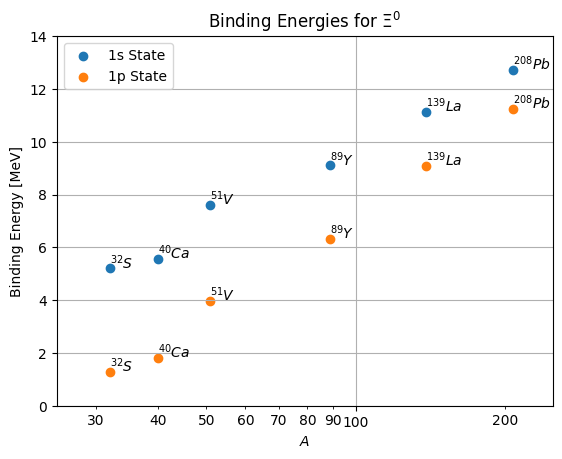

In [14]:
### Annotated Plot Including Binding Energies for Grho = 4.71

plt.scatter(AVec, -XiBE[0:6], label = '1s State')
plt.scatter(AVec, -XiBE[6:12], label = '1p State')

plt.xlim(25, 250)
plt.ylim(0, 14)
plt.xscale('log')

ax = plt.gca()

ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.get_major_formatter().set_useOffset(False)

plt.xlabel('$A$')
plt.ylabel('Binding Energy [MeV]')
plt.legend()
plt.grid()
plt.title('Binding Energies for $\Xi^0$')

plt.annotate('$^{208}Pb$', (208, -XiBE[0]))
plt.annotate('$^{139}La$', (139, -XiBE[1]))
plt.annotate('$^{89}Y$', (89, -XiBE[2]))
plt.annotate('$^{51}V$', (51, -XiBE[3]))
plt.annotate('$^{40}Ca$', (40, -XiBE[4]))
plt.annotate('$^{32}S$', (32, -XiBE[5]))
plt.annotate('$^{208}Pb$', (208, -XiBE[6]))
plt.annotate('$^{139}La$', (139, -XiBE[7]))
plt.annotate('$^{89}Y$', (89, -XiBE[8]))
plt.annotate('$^{51}V$', (51, -XiBE[9]))
plt.annotate('$^{40}Ca$', (40, -XiBE[10]))
plt.annotate('$^{32}S$', (32, -XiBE[11]))

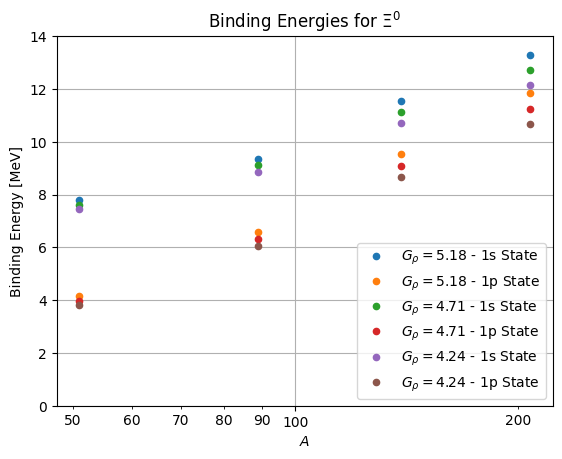

In [15]:
### Plot including different values of Grho, for terms where N =/= Z

plt.plot(AVec[0:4], -XiUpperBE[0:4], 'o', label=r'$G_\rho = 5.18$ - 1s State', markersize=4.5)
plt.plot(AVec[0:4], -XiUpperBE[6:10], 'o', label=r'$G_\rho = 5.18$ - 1p State', markersize=4.5)

plt.plot(AVec[0:4], -XiBE[0:4], 'o', label=r'$G_\rho = 4.71$ - 1s State', markersize=4.5)
plt.plot(AVec[0:4], -XiBE[6:10], 'o', label=r'$G_\rho = 4.71$ - 1p State', markersize=4.5)

plt.plot(AVec[0:4], -XiLowerBE[0:4], 'o', label=r'$G_\rho = 4.24$ - 1s State', markersize=4.5)
plt.plot(AVec[0:4], -XiLowerBE[6:10], 'o', label=r'$G_\rho = 4.24$ - 1p State', markersize=4.5)



plt.ylim(0, 14)
plt.xscale('log')

ax = plt.gca()

ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.get_major_formatter().set_useOffset(False)

plt.xlabel('$A$')
plt.ylabel('Binding Energy [MeV]')
plt.legend()
plt.grid()
plt.title('Binding Energies for $\Xi^0$')